# MIMIC-II IAC

In [1]:
import ehrapy.api as ep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cellrank as cr
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PseudotimeKernel
import scvelo as scv

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet 
connection?

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings
from matplotlib import MatplotlibDeprecationWarning

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

In [3]:
adata = ep.dt.mimic_2(encoded=True)

In [4]:
ep.pp.knn_impute(adata)

AnnData object with n_obs × n_vars = 1776 × 46
    obs: 'service_unit', 'day_icu_intime'
    uns: 'categoricals', 'original_values_categoricals', 'var_to_encoding'
    layers: 'original'

In [5]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

... storing 'service_unit' as categorical
... storing 'day_icu_intime' as categorical


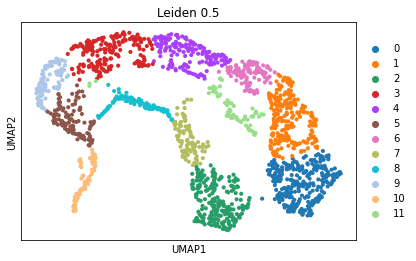

In [6]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

We have to find some root/origin visit. Cluster 0 looks suitable. Usually identified by some marker feature.

In [7]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_0_5'] == '0')[0]
ep.tl.dpt(adata)

In [8]:
pk = PseudotimeKernel(adata)
pk.compute_transition_matrix()
pk.compute_projection(basis="umap")

  0%|          | 0/1776 [00:00<?, ?cell/s]

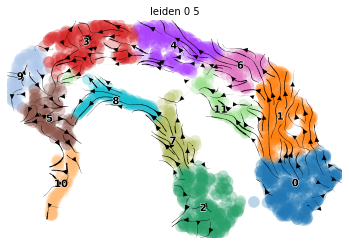

In [9]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

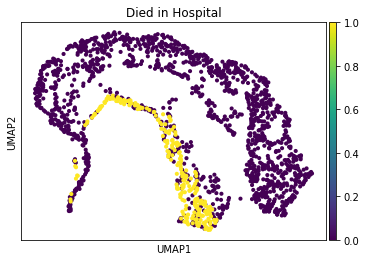

In [10]:
ep.pl.umap(adata, color="hosp_exp_flg", title="Died in Hospital")

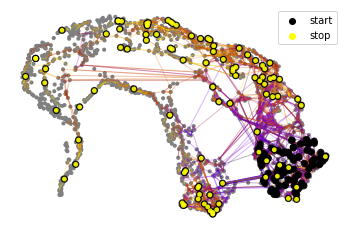

In [11]:
pk.plot_random_walks(
    100,
    start_ixs={"leiden_0_5": "0"},
    max_iter=100,
    show_progress_bar=False,
    ixs_legend_loc="best",
    seed=42,
)

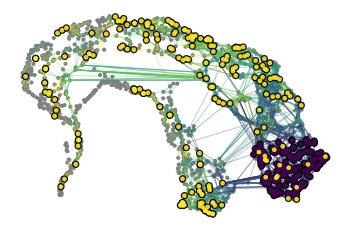

In [12]:
pk.plot_random_walks(
    200,
    start_ixs={"leiden_0_5": "0"},
    stop_ixs={"leiden_0_5": ["8", "7", "2"]},
    max_iter=100,
    successive_hits=50,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

## Determining terminal states.

In [13]:
g = cr.tl.estimators.GPCCA(pk)

In [14]:
g.compute_schur(n_components=3)

In [15]:
g.compute_macrostates(n_states=5, cluster_key="leiden_0_5")

In [16]:
g.macrostates_memberships

0_1,0_2,2,6,10
0.001385,0.019005,0.004843,0.369932,0.604835
0.001782,0.280451,0.017553,0.678999,0.021215
0.002671,0.003973,0.015464,0.602741,0.375151
0.000959,0.024435,0.002955,0.329411,0.642240
0.002744,0.000702,0.012142,0.526913,0.457498
0.002329,0.013797,0.018059,0.665589,0.300225
0.000970,0.269982,0.020706,0.703510,0.004831
0.000000,0.163363,0.018737,0.770395,0.047504
0.000233,0.220802,0.016001,0.743725,0.019239
0.000298,0.032867,0.000459,0.276161,0.690216


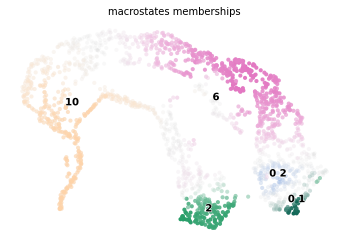

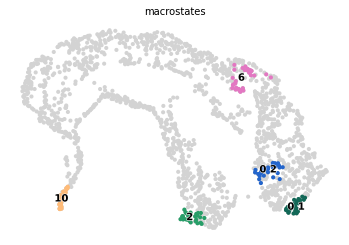

In [17]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

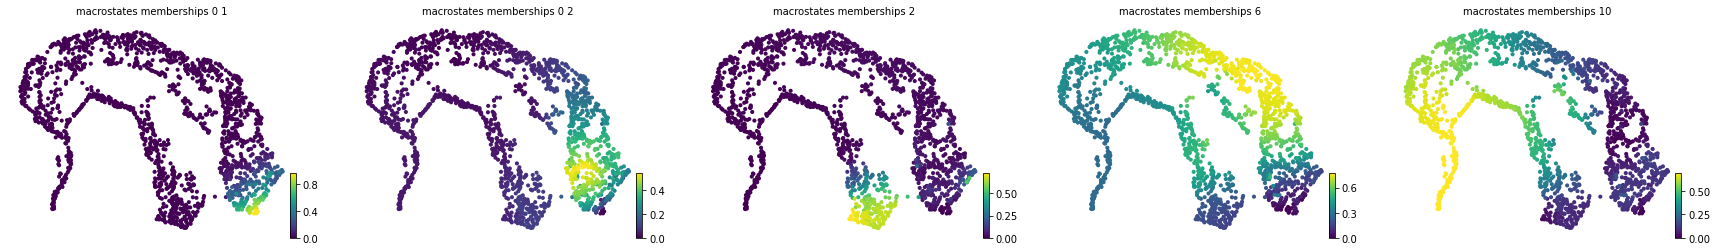

In [18]:
g.plot_macrostates(same_plot=False)

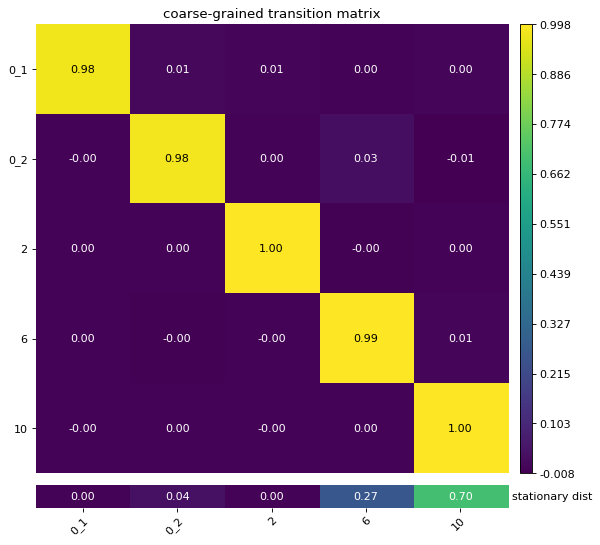

In [19]:
g.plot_coarse_T(text_kwargs={"fontsize": 10})

In [20]:
g.compute_terminal_states()

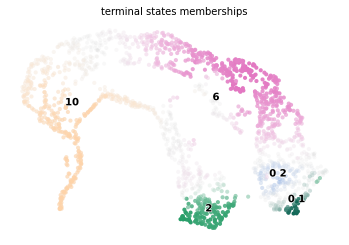

In [21]:
g.plot_terminal_states()

In [22]:
g.compute_absorption_probabilities(preconditioner='ilu', tol=1e-10)

Defaulting to `'gmres'` solver.


  0%|          | 0/5 [00:00<?, ?/s]

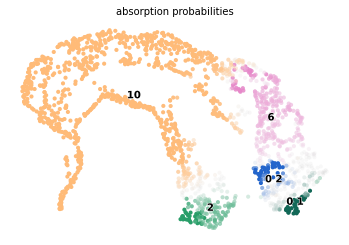

In [23]:
g.plot_absorption_probabilities()

In [24]:
g.compute_absorption_probabilities(time_to_absorption="all", preconditioner='ilu', tol=1e-10)
g.absorption_times

  0%|          | 0/5 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?/s]

,"0_1, 0_2, 2, 6, 10 mean"
0,179.287567
1,112.491760
2,286.910187
3,146.307037
4,262.389893
...,...
1771,0.000000
1772,116.465927
1773,0.000000
1774,107.240761


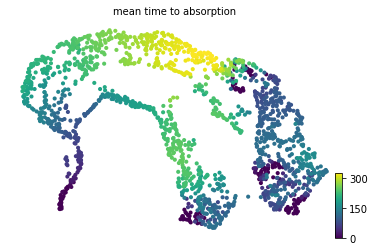

In [25]:
adata.obs["mean_time_to_absorption"] = g.absorption_times["0_1, 0_2, 2, 6, 10 mean"]
scv.pl.scatter(adata, color="mean_time_to_absorption")

In [26]:
g.compute_lineage_drivers()

,0_1_corr,0_1_pval,0_1_qval,0_1_ci_low,0_1_ci_high,0_2_corr,0_2_pval,0_2_qval,0_2_ci_low,0_2_ci_high,...,6_corr,6_pval,6_qval,6_ci_low,6_ci_high,10_corr,10_pval,10_qval,10_ci_low,10_ci_high
platelet_first,0.144281,9.479599e-10,NaN,0.098428,0.189523,0.081711,5.641817e-04,NaN,0.035331,0.127739,...,0.015502,5.138921e-01,NaN,-0.031034,0.061971,-0.108203,4.784479e-06,NaN,-0.153942,-0.062002
censor_flg,0.135713,8.927138e-09,NaN,0.089766,0.181084,0.183822,4.910575e-15,NaN,0.138492,0.228383,...,0.318567,6.562423e-44,NaN,0.276145,0.359750,-0.032764,1.675558e-01,NaN,-0.079157,0.013770
mort_day_censored,0.074304,1.721525e-03,NaN,0.027887,0.120401,0.098859,2.963149e-05,NaN,0.052587,0.144707,...,0.185240,2.997285e-15,NaN,0.139933,0.229774,0.072421,2.252279e-03,NaN,0.025995,0.118535
weight_first,0.056532,1.717514e-02,NaN,0.010045,0.102775,0.047596,4.489295e-02,NaN,0.001085,0.093902,...,0.014157,5.510820e-01,NaN,-0.032378,0.060630,-0.002874,9.036864e-01,NaN,-0.049381,0.043646
bmi,0.054434,2.177145e-02,NaN,0.007941,0.100693,0.069637,3.314352e-03,NaN,0.023199,0.115776,...,0.021891,3.565776e-01,NaN,-0.024648,0.068335,-0.039565,9.554755e-02,NaN,-0.085920,0.006961
map_1st,0.039244,9.826709e-02,NaN,-0.007283,0.085602,0.015463,5.149454e-01,NaN,-0.031073,0.061932,...,0.033593,1.570563e-01,NaN,-0.012941,0.079982,-0.025010,2.922023e-01,NaN,-0.071440,0.021529
ehrapycat_day_icu_intime,0.031812,1.802547e-01,NaN,-0.014723,0.078210,0.023866,3.148349e-01,NaN,-0.022673,0.070302,...,0.011347,6.327997e-01,NaN,-0.035186,0.057830,-0.028661,2.273746e-01,NaN,-0.075074,0.017877
tco2_first,0.025642,2.801641e-01,NaN,-0.020896,0.072070,0.025670,2.796446e-01,NaN,-0.020869,0.072097,...,-0.029887,2.080969e-01,NaN,-0.076294,0.016650,-0.079760,7.637669e-04,NaN,-0.125807,-0.033370
sodium_first,0.020941,3.778352e-01,NaN,-0.025598,0.067389,0.002142,9.281370e-01,NaN,-0.044376,0.048651,...,0.031003,1.916019e-01,NaN,-0.015533,0.077405,-0.005275,8.242164e-01,NaN,-0.051776,0.041249
hgb_first,0.013289,5.757655e-01,NaN,-0.033245,0.059765,0.026189,2.700245e-01,NaN,-0.020349,0.072614,...,0.044765,5.927175e-02,NaN,-0.001752,0.091089,0.001463,9.508698e-01,NaN,-0.045053,0.047974


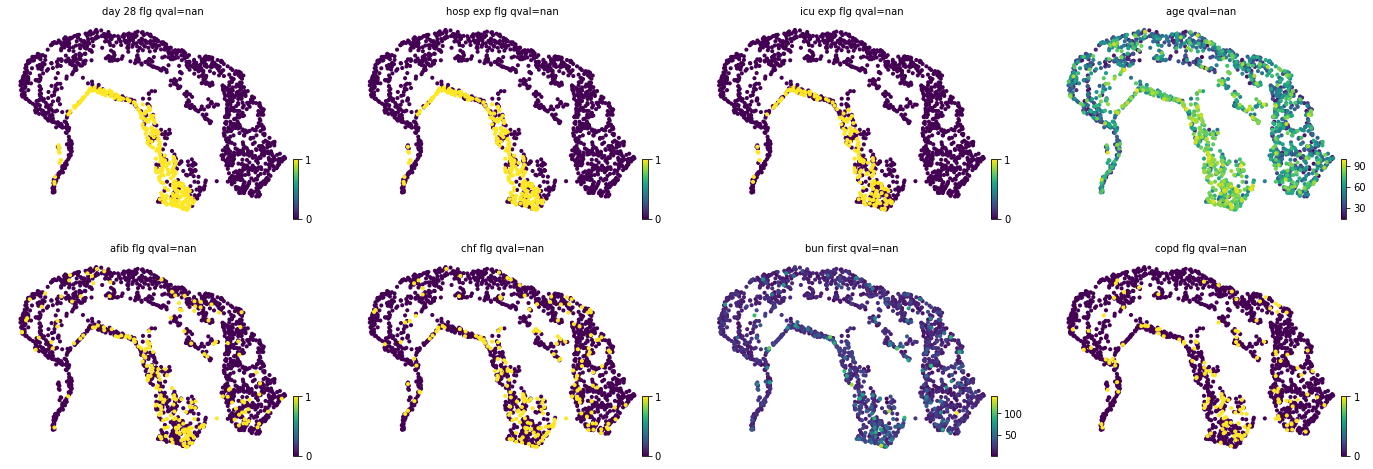

In [27]:
g.plot_lineage_drivers(lineage="2")

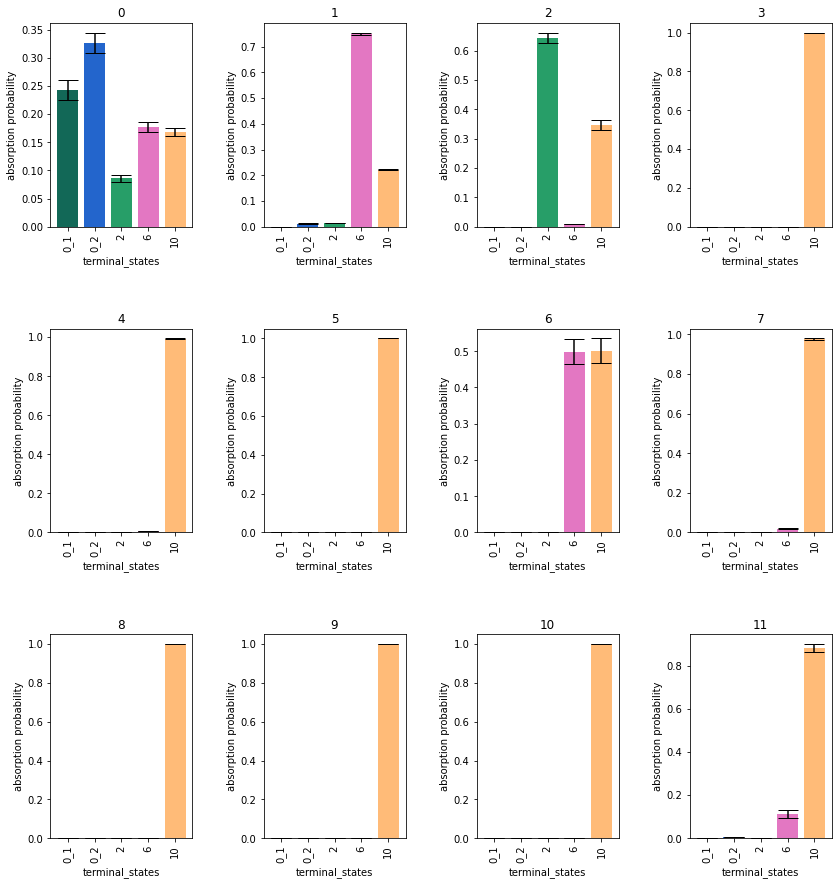

In [28]:
cr.pl.cluster_fates(adata, mode="bar", cluster_key="leiden_0_5")

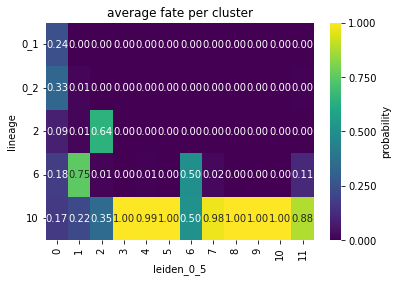

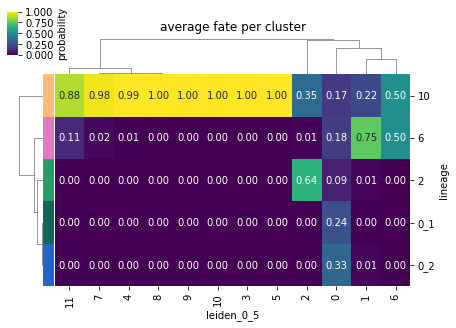

In [29]:
cr.pl.cluster_fates(adata, mode="heatmap", cluster_key="leiden_0_5")
cr.pl.cluster_fates(adata, mode="clustermap", cluster_key="leiden_0_5")

In [30]:
ep.tl.paga(adata, groups="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(


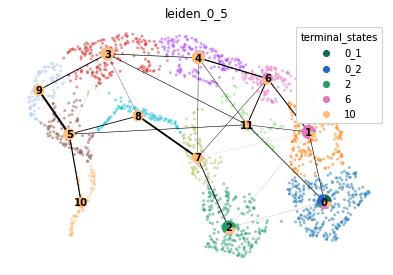

In [31]:
cr.pl.cluster_fates(adata, mode="paga_pie", basis="umap", cluster_key="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/dra

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(


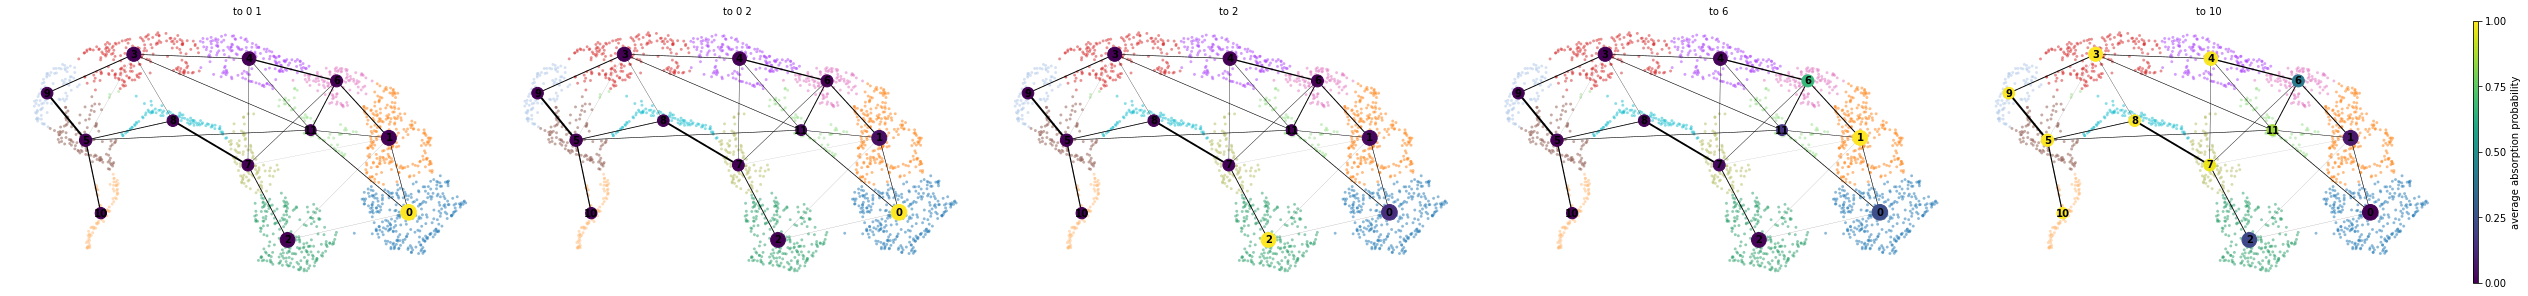

In [32]:
cr.pl.cluster_fates(adata, mode="paga", legend_loc="on data", basis="umap", cluster_key="leiden_0_5")

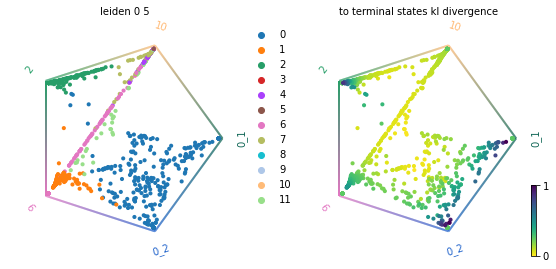

In [33]:
cr.pl.circular_projection(
    adata, keys=["leiden_0_5", "kl_divergence"], legend_loc="upper right"
)

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

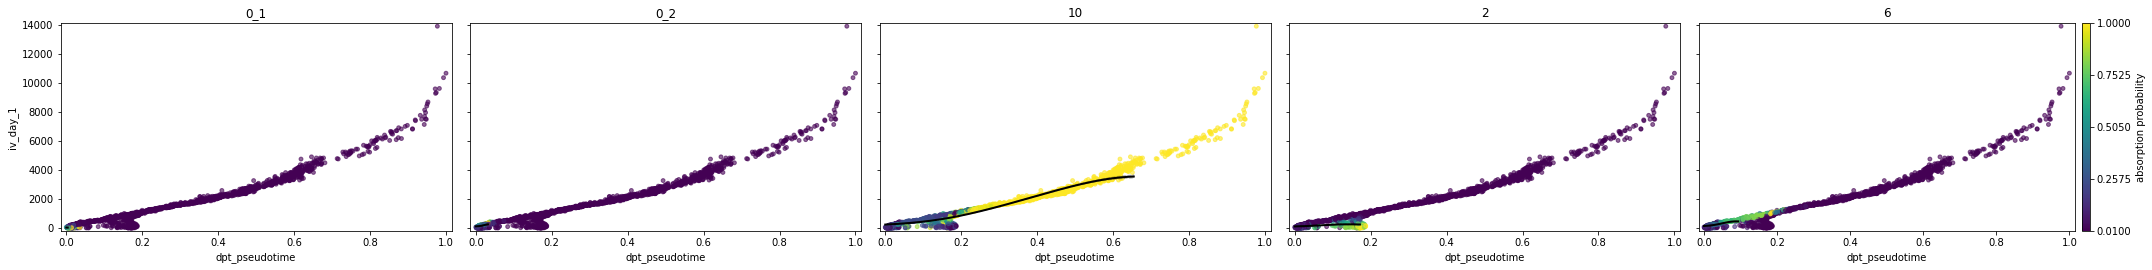

In [34]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

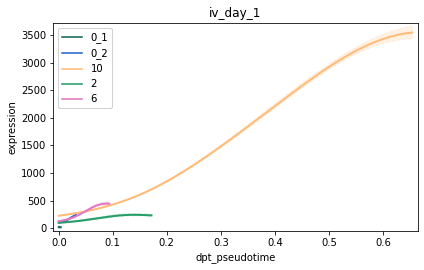

In [35]:
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    same_plot=True,
    hide_cells=True,
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)